In [7]:
import geopandas as gpd
import numpy as np
import pandas as pd
import pyarrow

import pysal as ps
import matplotlib.pyplot as plt
import matplotlib.collections as mplc
%matplotlib inline
import seaborn as sns
import shapely

from shapely import geometry as sgeom
from shapely.geometry import Point
from shapely import ops

import warnings
warnings.simplefilter('ignore') 

In [41]:
consco_path = 'connectivity_scores_EW.parquet'

lsoa_gdf = gpd.read_file('../lsoa_eng_wales.shp')
con_data = pd.read_parquet('../' + consco_path, engine='pyarrow')
con_data = con_data.rename(columns={'lsoa':'lsoa11cd'})

In [42]:
lsoa_gdf

,objectid,lsoa11cd,lsoa11nm,lsoa11nmw,st_areasha,st_lengths,geometry
0,1,E01000001,City of London 001A,City of London 001A,1.333208e+05,2291.846072,"POLYGON ((-0.09726 51.52158, -0.09649 51.52028..."
1,2,E01000002,City of London 001B,City of London 001B,2.261913e+05,2433.960112,"POLYGON ((-0.08810 51.51941, -0.08927 51.51752..."
2,3,E01000003,City of London 001C,City of London 001C,5.730297e+04,1142.359799,"POLYGON ((-0.09676 51.52325, -0.09644 51.52282..."
3,4,E01000005,City of London 001E,City of London 001E,1.907388e+05,2167.868343,"POLYGON ((-0.07320 51.51000, -0.07551 51.50974..."
4,5,E01000006,Barking and Dagenham 016A,Barking and Dagenham 016A,1.441958e+05,1935.510354,"POLYGON ((0.09118 51.53909, 0.09328 51.53787, ..."
...,...,...,...,...,...,...,...
34748,34749,W01001954,Cardiff 006F,Caerdydd 006F,6.471879e+05,5353.810154,"POLYGON ((-3.25546 51.52101, -3.25489 51.51968..."
34749,34750,W01001955,Swansea 025F,Abertawe 025F,6.900149e+05,5776.750473,"POLYGON ((-3.94053 51.63059, -3.93913 51.62702..."
34750,34751,W01001956,Swansea 023E,Abertawe 023E,2.493308e+06,12586.351015,"POLYGON ((-4.02465 51.63615, -4.02458 51.63574..."
34751,34752,W01001957,Swansea 025G,Abertawe 025G,2.144800e+05,2635.105196,"POLYGON ((-3.94920 51.61754, -3.94814 51.61670..."


In [22]:
con_data.columns

Index(['lsoa', 'Education_car', 'Business_car', 'Shopping_car',
       'Education_walk', 'Business_pt', 'Education_pt',
       'Visit friends at private home_car', 'Entertain / public activity_car',
       'Business_walk', 'Shopping_walk', 'Business_cycling',
       'Education_cycling', 'Shopping_pt', 'Entertain / public activity_pt',
       'Visit friends at private home_pt', 'Shopping_cycling',
       'Entertain / public activity_walk',
       'Visit friends at private home_walk',
       'Entertain / public activity_cycling',
       'Visit friends at private home_cycling', 'overall', 'overall_walk',
       'overall_car', 'overall_cycling', 'overall_pt', 'overall_business',
       'overall_education', 'overall_entertain', 'overall_shopping',
       'overall_visit', 'Education_car_decile', 'Business_car_decile',
       'Shopping_car_decile', 'Education_walk_decile', 'Business_pt_decile',
       'Education_pt_decile', 'Visit friends at private home_car_decile',
       'Entertain / publi

In [33]:
# define the spatial weight
def SpatialWeight(gdf,indicator=''):
    from libpysal.weights import Queen

    # Create the spatial weights matrix by Queen
    w_queen = Queen.from_dataframe(gdf)
    if w_queen.pct_nonzero == 0:
        print ('Error: %.4f'%w_queen.pct_nonzero)
    else:
        gdf.to_file(driver='ESRI Shapefile', filename='../lsoa_consco.shp')
        W_queen = ps.lib.weights.Queen.from_shapefile('../lsoa_consco.shp')
        W_queen.transform = 'r' # row-standardize the contiguity weights
        Spatial_Lag = ps.lib.weights.lag_spatial(W_queen, gdf[indicator]) #spatial lag of the HPI
    
        return w_queen, Spatial_Lag

In [52]:

# calculate Moran's I index
def MoransI(gdf, graph = '', indicator=''):
    from pysal.explore import esda
    if graph == 'scatter':
        # Moran Scatter plot
        accidents=gdf[indicator]
        _, accidents_Lag = SpatialWeight(gdf,indicator=indicator)

        b,a = np.polyfit(accidents, accidents_Lag, 1)
        f, ax = plt.subplots(1, figsize=(10, 8))
        plt.plot(accidents, accidents_Lag, '.', color='firebrick')

        # dashed vert at mean of the last year's private rent level
        plt.vlines(accidents.mean(), accidents_Lag.min(), accidents_Lag.max(), linestyle='--')
        # dashed horizontal at mean of lagged private rent
        plt.hlines(accidents_Lag.mean(), accidents.min(), accidents.max(), linestyle='--')

        # red line of best fit using global I as slope
        plt.plot(accidents, a + b*accidents, 'r')
#         plt.title('Moran Scatterplot', fontsize=14)
        plt.ylabel('Spatial Lag of connectivity score of {}'.format(indicator))
        plt.xlabel('The SWI index of connectivity score of {}'.format(indicator))
    
    elif graph == 'reference':
        # Reference Distribution
        # call moran function
        w_queen, _ = SpatialWeight(gdf,indicator=indicator)
        mi = esda.moran.Moran(gdf[indicator], w_queen) 
        # print out the moran's I value
        print("The moran's I value is {} with p-value of {} and z-score of {}".format(mi.I, mi.p_sim, mi.z_sim))

        plt.figure(figsize=(8,6)) 
        sns.kdeplot(mi.sim, shade=True)
        plt.vlines(mi.I, 0, 40, color='r')
        plt.vlines(mi.EI, 0, 40)
        plt.xlabel("Moran's I")
#         plt.title("Reference Distribution", fontsize=14)


In [53]:
# plot LISA at LSOA level
def LISA(gdf,indicator=''):
    w_queen, _ = SpatialWeight(gdf,indicator=indicator)
    
    # Local spatial autocorrelation
    lisa = ps.explore.esda.Moran_Local(gdf[indicator].values, w_queen, permutations=999)
    
    gdf['lag_rate'] = ps.lib.weights.lag_spatial(w_queen, gdf[indicator])
    sigs = gdf[indicator][lisa.p_sim <= .05]
    W_sigs = gdf['lag_rate'][lisa.p_sim <= .05]
    insigs = gdf[indicator][lisa.p_sim > .05]
    W_insigs = gdf['lag_rate'][lisa.p_sim > .05]
    
    # plot LISA cluster map
    from pysal.viz.splot.esda import lisa_cluster
    fig_lisa, ax_lisa=plt.subplots(1, figsize=(14,10))
    fig_lisa = lisa_cluster(lisa, gdf, ax=ax_lisa)
    plt.title("LISA Cluster Map for connectivity score of {}".format(indicator), fontsize=14)
    plt.show()
    return lisa


In [43]:
# calculate SWI index of accidents in each LSOA
# accidents_lsoa = con_data.groupby('lsoa')['SWI'].count()
joint_gdf_con = lsoa_gdf.merge(con_data,on='lsoa11cd', how='outer')
joint_gdf_con = gpd.GeoDataFrame(joint_gdf_con, geometry=joint_gdf_con['geometry'])

('WARNING: ', 18535, ' is an island (no neighbors)')
('WARNING: ', 18535, ' is an island (no neighbors)')
The moran's I value is 0.9516735773490488 with p-value of 0.001 and z-score of 291.3758736732701
('WARNING: ', 18535, ' is an island (no neighbors)')
('WARNING: ', 18535, ' is an island (no neighbors)')
('WARNING: ', 18535, ' is an island (no neighbors)')
The moran's I value is 0.9057274042769138 with p-value of 0.001 and z-score of 281.43817392469634
('WARNING: ', 18535, ' is an island (no neighbors)')
('WARNING: ', 18535, ' is an island (no neighbors)')
('WARNING: ', 18535, ' is an island (no neighbors)')
The moran's I value is 0.9599441382992893 with p-value of 0.001 and z-score of 286.96519788128575
('WARNING: ', 18535, ' is an island (no neighbors)')
('WARNING: ', 18535, ' is an island (no neighbors)')
('WARNING: ', 18535, ' is an island (no neighbors)')
The moran's I value is 0.9524380530354679 with p-value of 0.001 and z-score of 286.69245852344613
('WARNING: ', 18535, ' is 

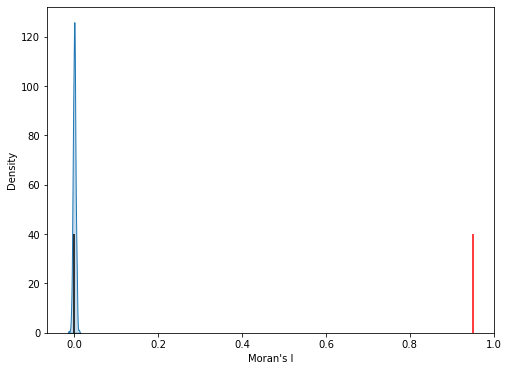

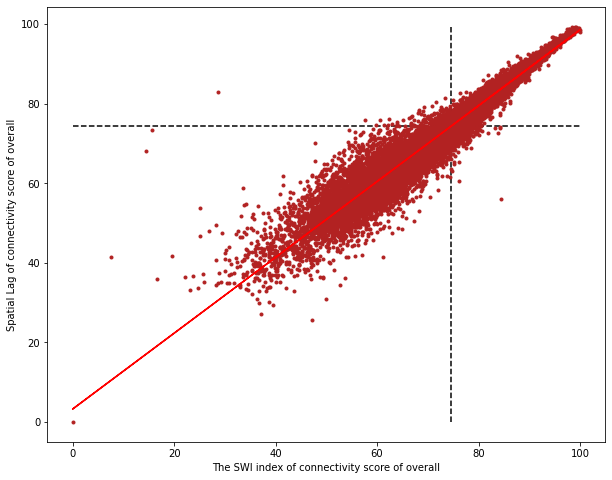

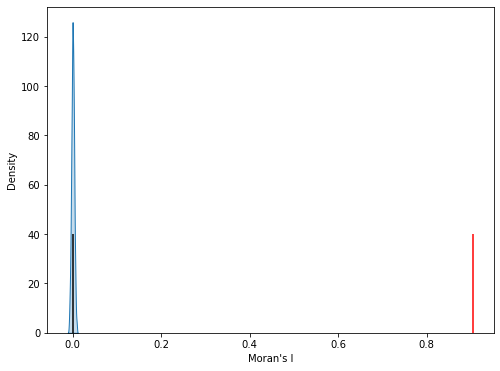

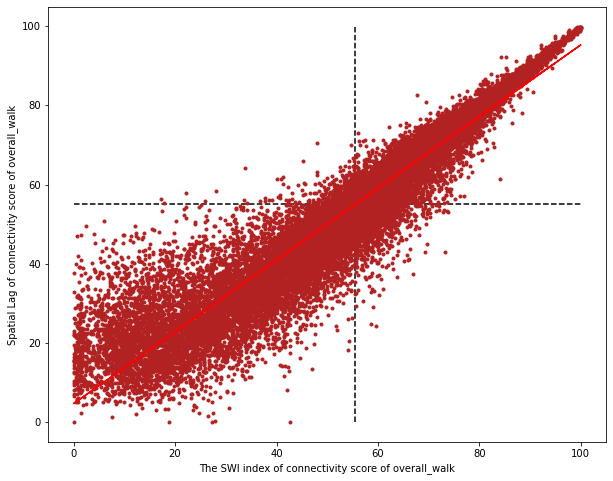

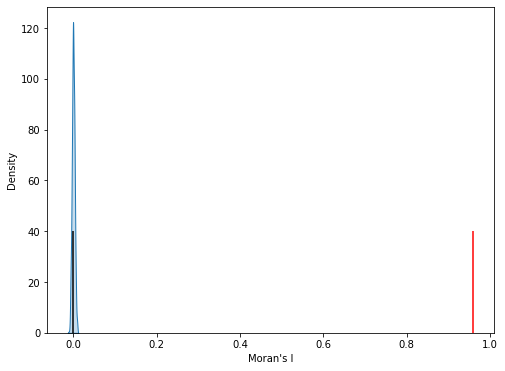

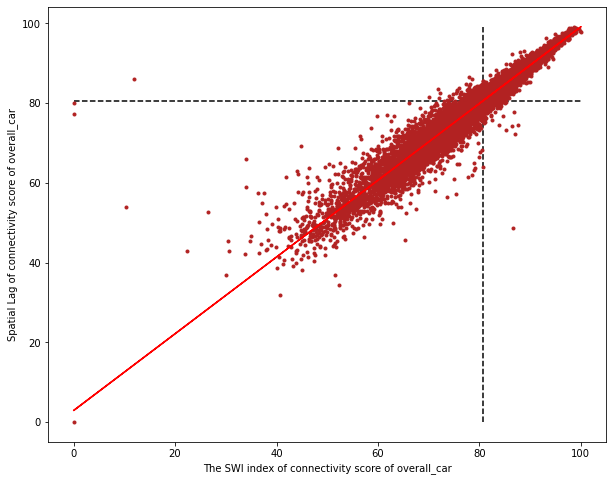

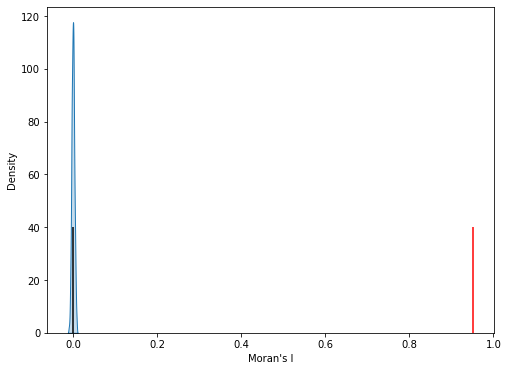

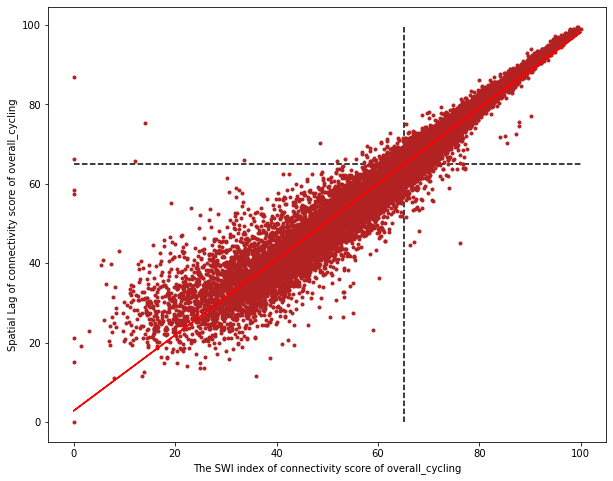

In [54]:
# plot reference distribution
mode_ls = ['overall', 'overall_walk', 'overall_car', 'overall_cycling']

for i in range(len(mode_ls)):
    MoransI(joint_gdf_con, graph='reference', indicator=mode_ls[i])
    # plot scatter 
    MoransI(joint_gdf_con, graph='scatter', indicator=mode_ls[i])

('WARNING: ', 18535, ' is an island (no neighbors)')
('WARNING: ', 18535, ' is an island (no neighbors)')


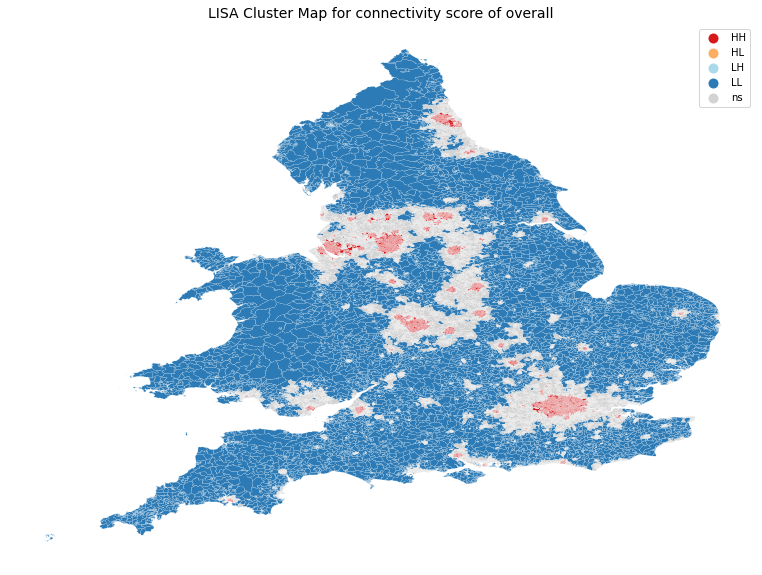

('WARNING: ', 18535, ' is an island (no neighbors)')
('WARNING: ', 18535, ' is an island (no neighbors)')


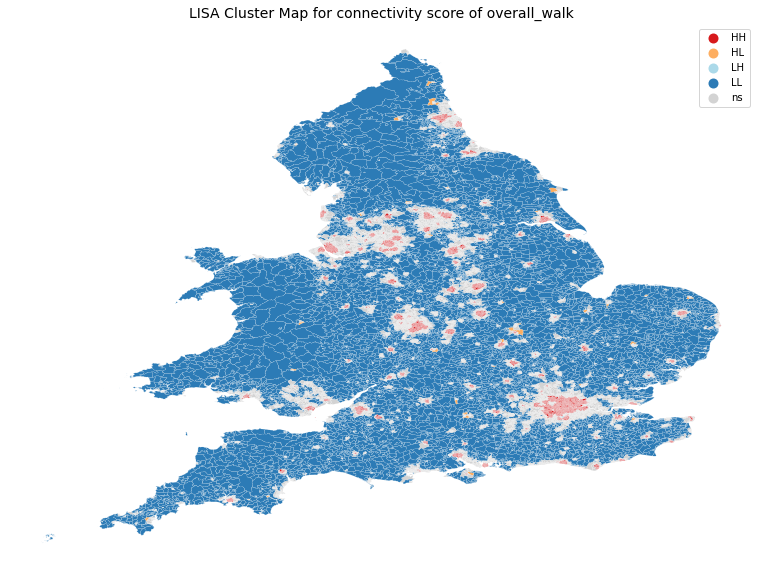

In [55]:
for i in range(len(mode_ls)):
    x = LISA(joint_gdf_con, indicator=mode_ls[i])